In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# change amount of infomation displayed on output
pd.set_option('display.max_columns', 100)


# load data
df = pd.read_csv('./data/data.csv')

In [3]:
df.head()

# print cols with missing values
# print(df.columns[df.isnull().any()])
# no missing values




,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

<AxesSubplot:>

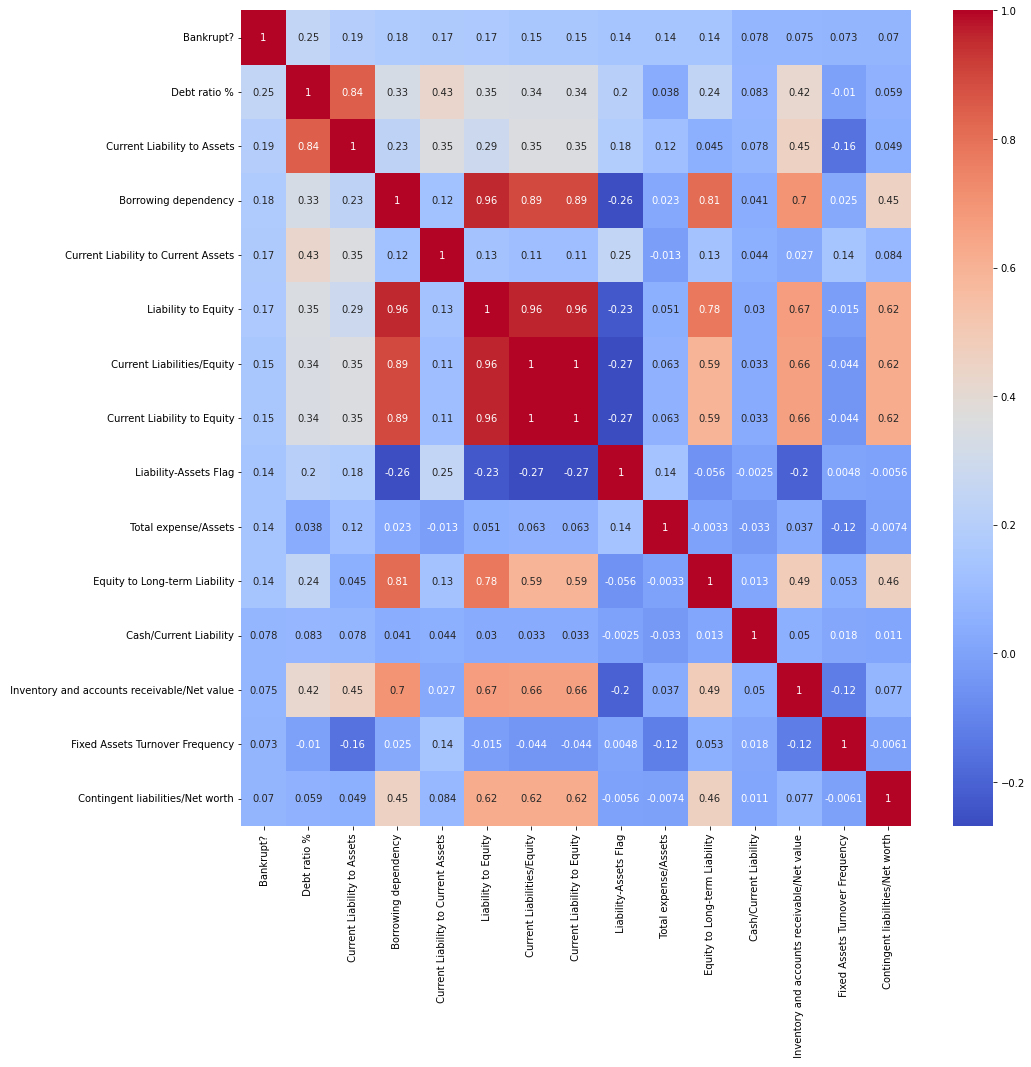

In [4]:
# print correlation matrix of all features
df.corr()
# visualize correlation matrix
# compute the correlation matrix
corr = df.corr()

# select the top 10 most correlated features with the target: 'Bankrupt?'
corr = corr.nlargest(15, 'Bankrupt?')['Bankrupt?'].index

# plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df[corr].corr(), annot=True, cmap='coolwarm')


In [5]:
# create train, test, validation sets
from sklearn.model_selection import train_test_split

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# split train into train and validation sets
train, val = train_test_split(train, test_size=0.2, random_state=42)

# print shapes of train, test, validation sets
print(train.shape, test.shape, val.shape)


(4364, 96) (1364, 96) (1091, 96)


In [6]:
# save train, test, validation sets
train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)
val.to_csv('./data/val.csv', index=False)

## Feature Selection

In [8]:
# look at correlation between features and target in train set (absolute value)
train.corr()['Bankrupt?'].abs().sort_values(ascending=False)

# compute class conditional means
train.groupby('Bankrupt?').mean()
train.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4364 entries, 2300 to 2644
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 4364 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  4364 non-null   float64
 2    ROA(A) before interest and % after tax                   4364 non-null   float64
 3    ROA(B) before interest and depreciation after tax        4364 non-null   float64
 4    Operating Gross Margin                                   4364 non-null   float64
 5    Realized Sales Gross Margin                              4364 non-null   float64
 6    Operating Profit Rate                                    4364 non-null   float64
 7    Pre-tax net Interest Rate                                4364 non-null   float64
 8    After-tax net 

## Linear Classification
Overview:

We are doing binary classification. Given a feature vector $x$, we want to predict a label $y$.

Goal: learn distribution $p(y|x)$

$\hat{y} = \arg\max_y p(y|x)$ is the prediction 

Binary classifier of the form:
$\Beta^T x + \gamma \lessgtr 0$


$p(y=j) = \pi_j$ for $j=0,1$, 0 representing not bankrupt and 1 representing bankrupt.

Assuming $p(x|y=j)$ is Gaussian with mean $\mu_j$ and covariance $\Sigma_j$.
$$p(x|y=j)=\frac{1}{\sqrt{2\pi |\Sigma_j|}}\exp\left(-\frac{1}{2}(x-\mu_j)^T\Sigma_j^{-1}(x-\mu_j)\right)$$

We can consider the log-likelihood of the data given the parameters:

$ln(p(x,y|\pi,\mu,\Sigma)) \doteq -\frac{1}{2}ln(|\Sigma_j|) - \frac{1}{2}(x-\mu_j)^T\Sigma_j^{-1}(x-\mu_j)$
$= x^T A_j x + \Beta_j^T x + \gamma_j$

For symmetric matrix $A_j$, vector $\Beta_j$ and scalar $\gamma_j$. 



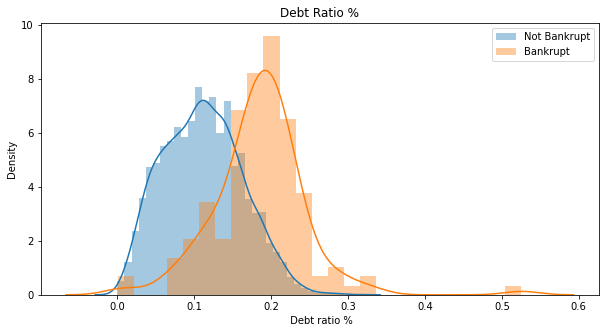

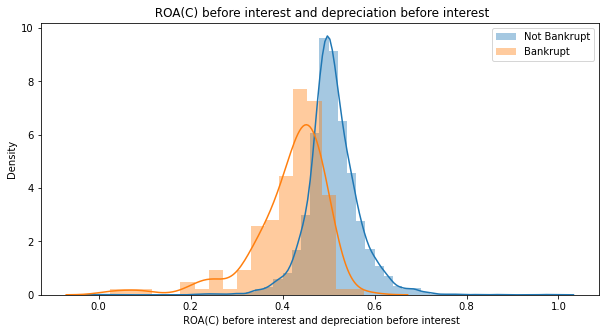

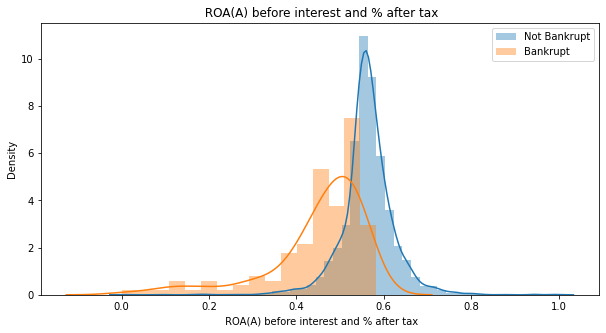

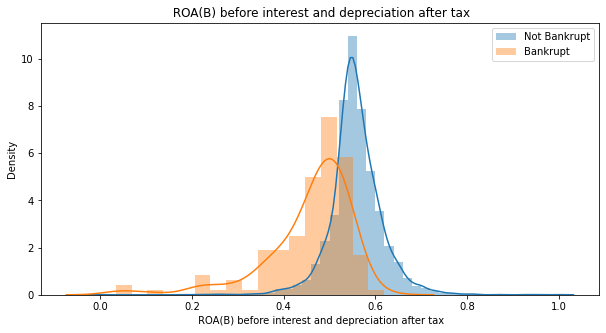

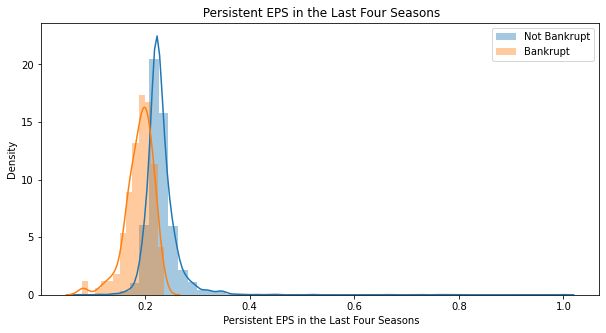

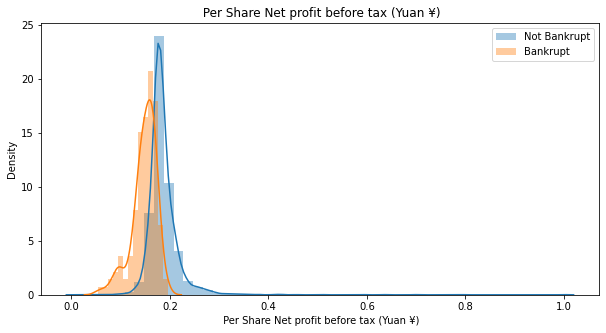

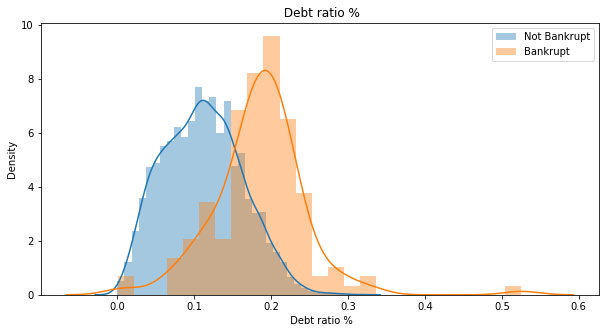

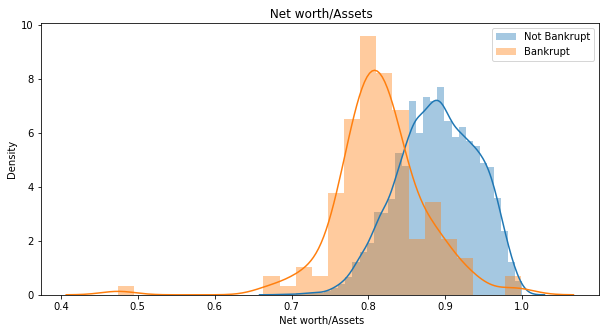

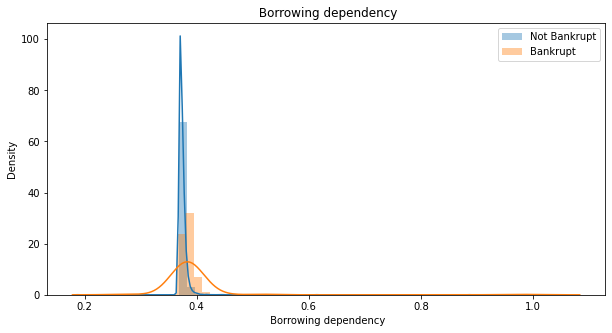

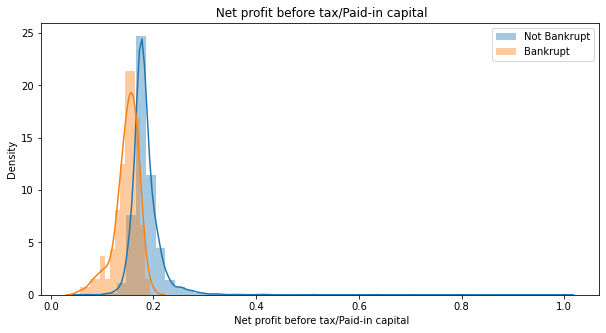

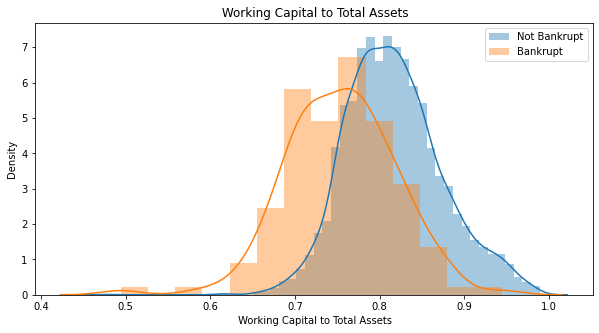

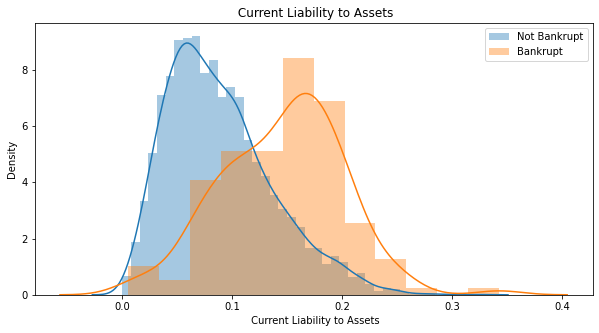

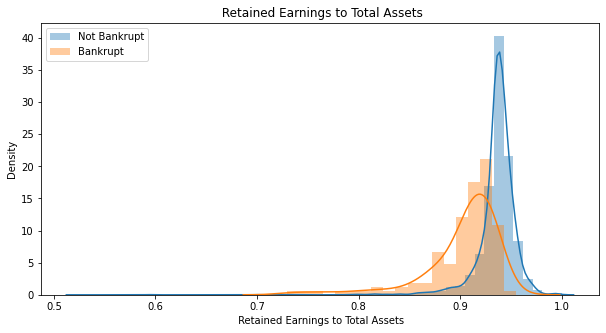

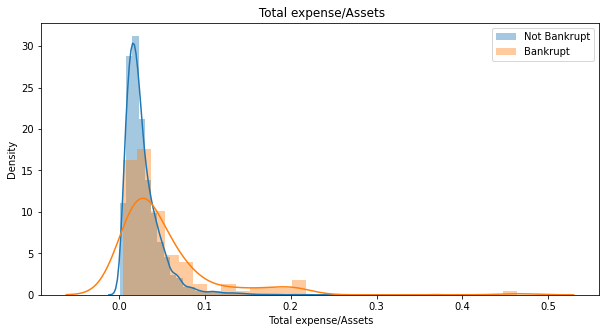

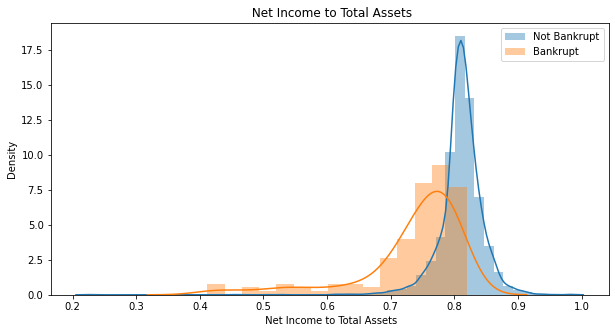

In [30]:
X, y = train.drop('Bankrupt?', axis=1), train['Bankrupt?']

# class conditional for Debt Ratio %
mu_0 = train[' Debt ratio %'][train['Bankrupt?'] == 0].mean()
mu_1 = train[' Debt ratio %'][train['Bankrupt?'] == 1].mean()
sigma_0 = train[' Debt ratio %'][train['Bankrupt?'] == 0].std()
sigma_1 = train[' Debt ratio %'][train['Bankrupt?'] == 1].std()

# plot class conditional distributions
plt.figure(figsize=(10, 5))
sns.distplot(train[' Debt ratio %'][train['Bankrupt?'] == 0], label='Not Bankrupt')
sns.distplot(train[' Debt ratio %'][train['Bankrupt?'] == 1], label='Bankrupt')
plt.legend()
plt.title('Debt Ratio %')
plt.show()

# now do the same for the top 15 most correlated features
top_features = train.corr()['Bankrupt?'].abs().sort_values(ascending=False).index[:15]

mu = {}
sigma = {}
for col in train.columns:
    if col == 'Bankrupt?' or col not in top_features:
        continue
    mu[col] = {}
    sigma[col] = {}
    mu[col][0] = train[col][train['Bankrupt?'] == 0].mean()
    mu[col][1] = train[col][train['Bankrupt?'] == 1].mean()
    sigma[col][0] = train[col][train['Bankrupt?'] == 0].std()
    sigma[col][1] = train[col][train['Bankrupt?'] == 1].std()
    plt.figure(figsize=(10, 5))
    sns.distplot(train[col][train['Bankrupt?'] == 0], label='Not Bankrupt')
    sns.distplot(train[col][train['Bankrupt?'] == 1], label='Bankrupt')
    plt.legend()
    plt.title(col)
    plt.show()




/Users/franklinglance/anaconda3/envs/pytorch-nightly/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


{' ROA(C) before interest and depreciation before interest': {0: array([6.37457161, 5.97666485, 4.30807228, ..., 5.93257336, 6.00112774,
         5.37833565]),
  1: array([3.32066271, 1.58315193, 4.25213169, ..., 1.56178042, 1.59524252,
         3.86266032])},
 ' ROA(A) before interest and % after tax': {0: array([6.51663837, 5.73530426, 4.19224636, ..., 5.47252011, 6.11358557,
         5.8066388 ]),
  1: array([2.31640263, 1.57069783, 3.12610495, ..., 1.48375726, 1.72223621,
         2.70708835])},
 ' ROA(B) before interest and depreciation after tax': {0: array([6.54829433, 5.86082706, 4.44913325, ..., 6.22979931, 6.53463641,
         5.29787734]),
  1: array([2.88306585, 1.57798903, 3.66385906, ..., 1.73472163, 1.90026791,
         3.4239425 ])},
 ' Operating Gross Margin': {0: array([22.80661393, 22.54413771,  5.64116091, ..., 22.91407794,
         19.48268653, 19.50547831]),
  1: array([20.22071351, 18.90353643, 11.06946838, ..., 21.34734825,
         12.26266773, 25.59022588])},
